## Problem Statements / Goals
1. Using given temperature columns, prepare a dataset for predictive modelling. Each data point would be a window containing k consecutive 
parts (0, 1, 2, 3, .. kth part). The target label for each window would be the quality label of the kth part. 
2. **Feature Engineering:** Extract the Max/Min/Std of each temperature sensor value in the window. These will be input features for our model. 
3. Train a predictive model to predict the quality label of the kth wheel with the corresponding window features as input.  
4. The **goal** is not to build the most accurate model. The goal of this assignment is to see how you approach this problem, to see your programming and storytelling/documentation skills.

## Data Collection & Understanding
**Data Description** : 
 
* `data.csv` file contains time series data collected from four temperature sensors 
installed in a machine producing metal parts.  
* Each part can be identified using `part_id` column, and its production quality 
can be identified using label column. Data corresponding to each part can 
be extracted by grouping the data on `part_id` column. 
* Each part can either be good (`label` = `0`), or bad (`label` = `1`).  
* Each part takes 4 - 5 minutes to produce. The temperature values throughout 
this production are recorded in the four temperature columns given in the 
data. 

In [2]:
import pandas as pd
df = pd.read_csv('data (2).csv', dtype={'timestamp':'timestamp[s][pyarrow]', 'part_id':'string'})
df

,timestamp,part_id,temperature_1,temperature_2,temperature_3,temperature_4,label
0,2024-02-15 00:14:34,2124077390649042,439.1,424.1,536.0,518.6,0
1,2024-02-15 00:14:35,2124077390649042,438.9,423.9,535.9,518.7,0
2,2024-02-15 00:14:36,2124077390649042,438.7,423.6,535.6,518.9,0
3,2024-02-15 00:14:37,2124077390649042,438.4,423.4,535.4,519.0,0
4,2024-02-15 00:14:38,2124077390649042,438.2,423.2,535.2,519.2,0
...,...,...,...,...,...,...,...
99995,2024-02-17 22:43:14,2124087523419042,479.6,460.8,571.1,532.7,0
99996,2024-02-17 22:43:15,2124087523419042,479.8,460.7,571.2,533.0,0
99997,2024-02-17 22:43:16,2124087523419042,480.2,460.6,571.2,533.2,0
99998,2024-02-17 22:43:17,2124087523419042,480.4,460.4,571.3,533.4,0


## EDA
### Do basic data check / validations
* Check shape and size.
* Types of features (categorical, numerical, etc.)
* Checking if data types are correct set for the column.
* Checking for NULLs, outliers, not necessary features, scaling, etc.
* Checking if there is imbalance
* Running `df.info()` and `df.describe()` to get more insights from the data.

In [3]:
df.shape, df.size

((100000, 7), 700000)

In [4]:
df.info() # as there are no NULLs no imputation needed, no categorical data hence no encoding needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype                
---  ------         --------------   -----                
 0   timestamp      100000 non-null  timestamp[s][pyarrow]
 1   part_id        100000 non-null  string               
 2   temperature_1  100000 non-null  float64              
 3   temperature_2  100000 non-null  float64              
 4   temperature_3  100000 non-null  float64              
 5   temperature_4  100000 non-null  float64              
 6   label          100000 non-null  int64                
dtypes: float64(4), int64(1), string(1), timestamp[s][pyarrow](1)
memory usage: 5.3 MB


In [5]:
df.describe() # as the range of temperatures don't vary too much shows scaling is not needed

,timestamp,temperature_1,temperature_2,temperature_3,temperature_4,label
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2024-02-16 07:11:34,455.534524,440.114258,546.868253,517.654658,0.059700
min,2024-02-15 00:14:34,350.800000,329.600000,407.700000,435.600000,0.000000
25%,2024-02-15 08:53:16,440.600000,425.200000,532.600000,508.500000,0.000000
50%,2024-02-16 11:30:10,454.000000,441.300000,550.000000,518.300000,0.000000
75%,2024-02-16 21:32:45,472.600000,459.500000,567.200000,530.200000,0.000000
max,2024-02-17 22:43:18,501.200000,481.000000,582.700000,555.400000,1.000000
std,NaN,20.596332,23.310541,24.818341,17.513545,0.236931


In [6]:
df['label'].value_counts(normalize=True)*100 # o/p in percent - shows classes are imbalanced

label
0    94.03
1     5.97
Name: proportion, dtype: float64

### Box Plot for Outliers

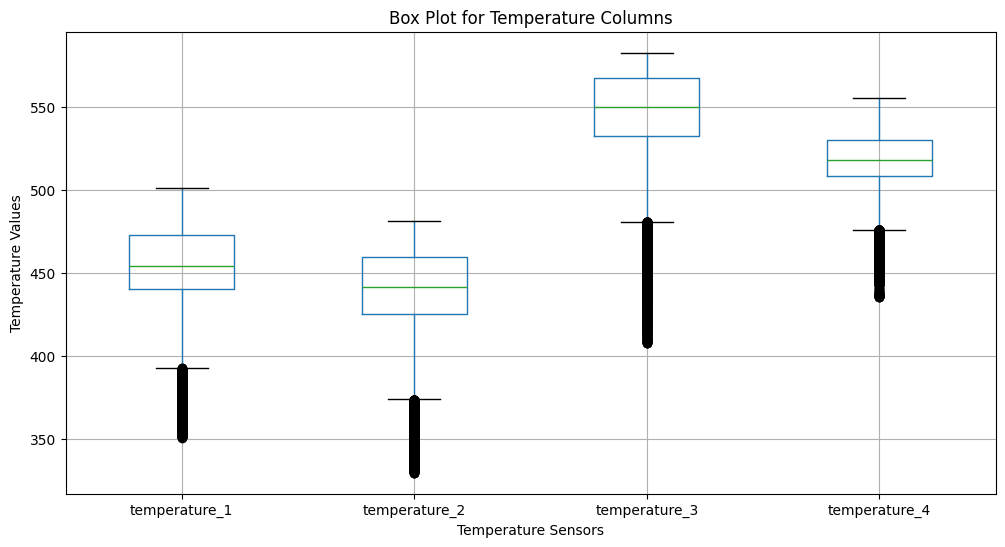

In [7]:
import matplotlib.pyplot as plt
temperature_columns = ['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4']
plt.figure(figsize=(12, 6))
df[temperature_columns].boxplot()
plt.title('Box Plot for Temperature Columns')
plt.ylabel('Temperature Values')
plt.xlabel('Temperature Sensors')
plt.show()


In [8]:
# Function to remove outliers using the IQR rule
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers
temperature_columns = ['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4']
df = remove_outliers_iqr(df, temperature_columns)
df.shape

(96355, 7)

In [9]:
df['label'].value_counts(normalize=True)*100 # o/p in percent - shows classes are imbalanced

label
0    94.285714
1     5.714286
Name: proportion, dtype: float64

### Visualize distributions of numerical features

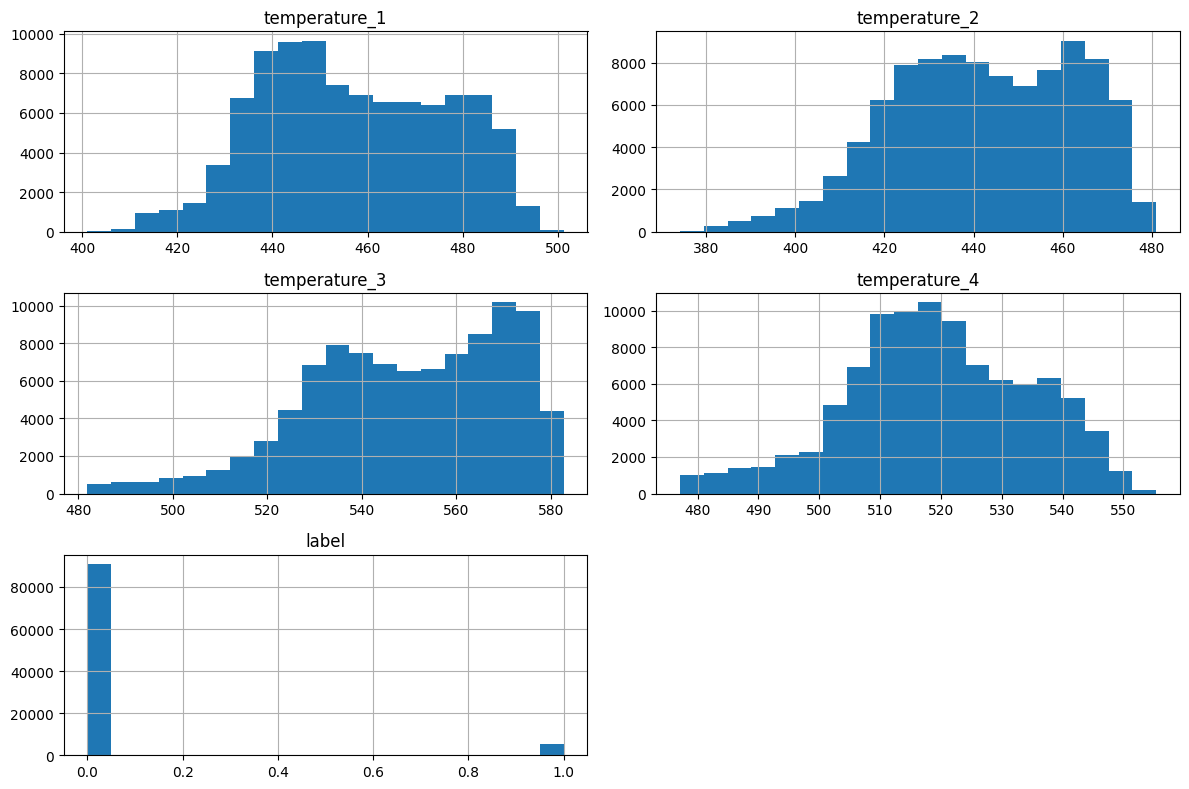

In [10]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [11]:
df.corr()

,timestamp,part_id,temperature_1,temperature_2,temperature_3,temperature_4,label
timestamp,1.000000,0.589879,-0.143926,-0.190942,-0.118254,-0.054050,-0.019752
part_id,0.589879,1.000000,-0.100287,-0.129951,-0.175047,-0.107029,-0.077920
temperature_1,-0.143926,-0.100287,1.000000,0.906852,0.880908,0.757667,0.042190
temperature_2,-0.190942,-0.129951,0.906852,1.000000,0.908588,0.730540,0.024330
temperature_3,-0.118254,-0.175047,0.880908,0.908588,1.000000,0.817578,0.016851
temperature_4,-0.054050,-0.107029,0.757667,0.730540,0.817578,1.000000,0.030406
label,-0.019752,-0.077920,0.042190,0.024330,0.016851,0.030406,1.000000


### Calculate the correlation matrix for numeric columns

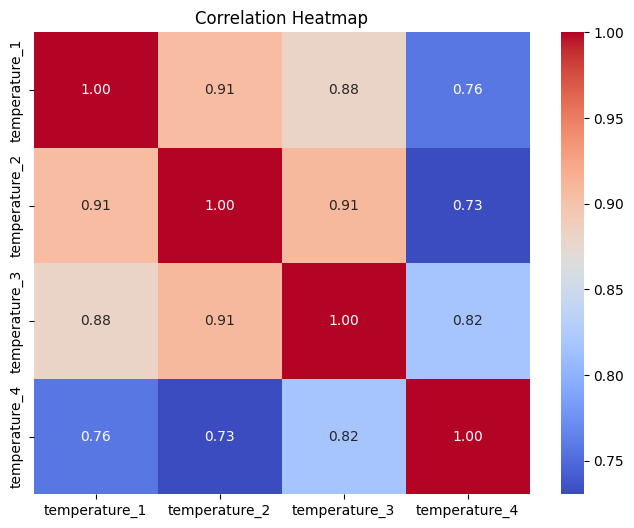

In [12]:
import seaborn as sns
correlation_matrix = df[['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap')
plt.show()


### Add the `label` column and calculate correlations

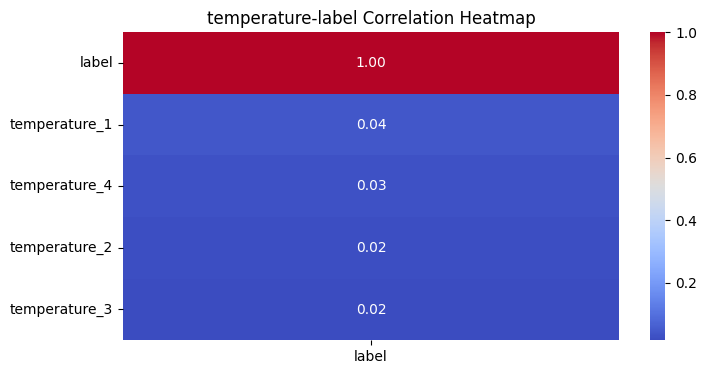

In [13]:
correlation_with_label = df[['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'label']].corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_with_label[['label']].sort_values(by='label', ascending=False), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('temperature-label Correlation Heatmap')
plt.show()

### Pairplot to visualize pairwise relationships


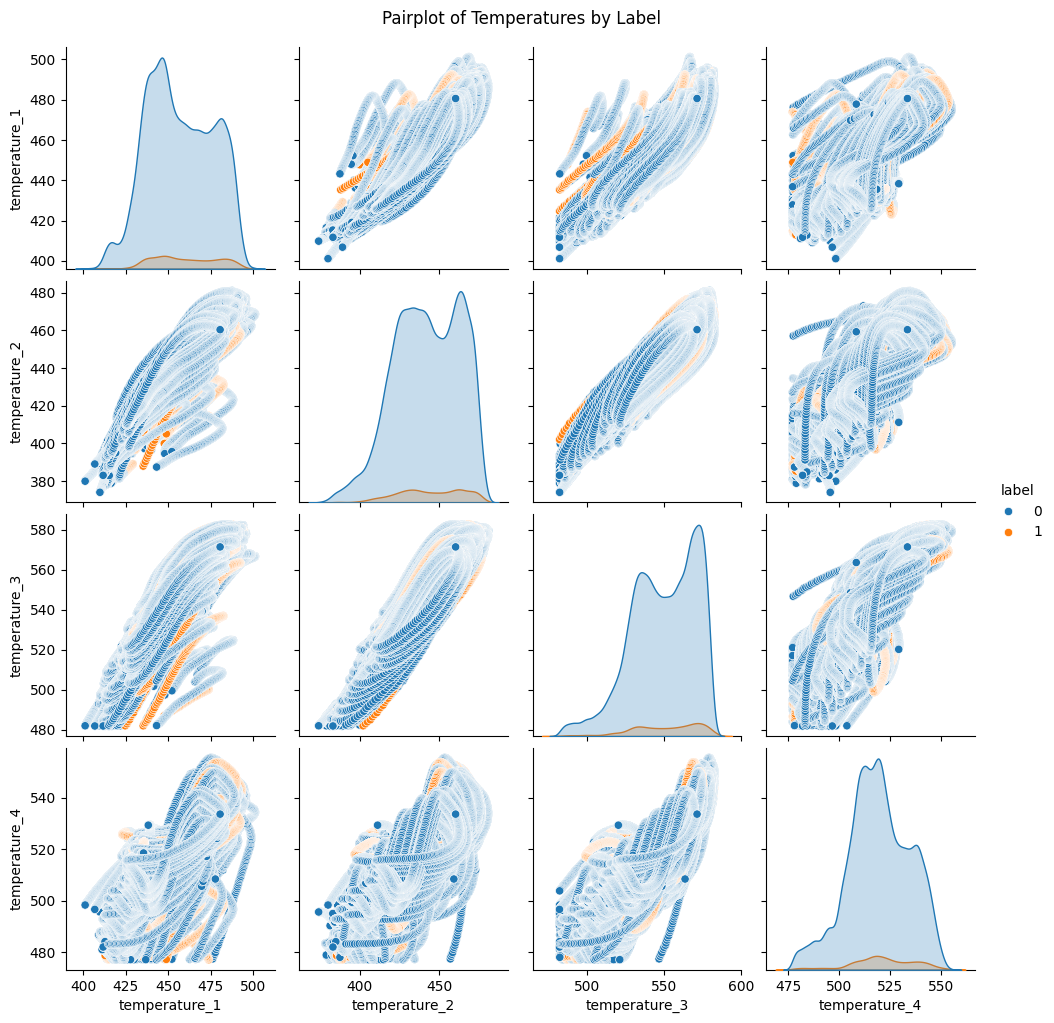

In [14]:
sns.pairplot(df, vars=['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4'], hue='label', diag_kind='kde')
plt.suptitle('Pairplot of Temperatures by Label', y=1.02)
plt.show()

### Scatterplots for each `temperature` column vs `label`

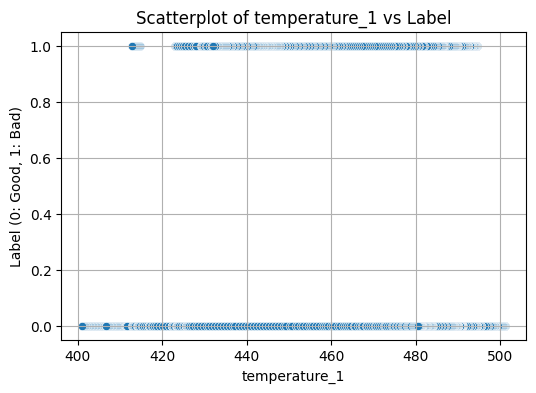

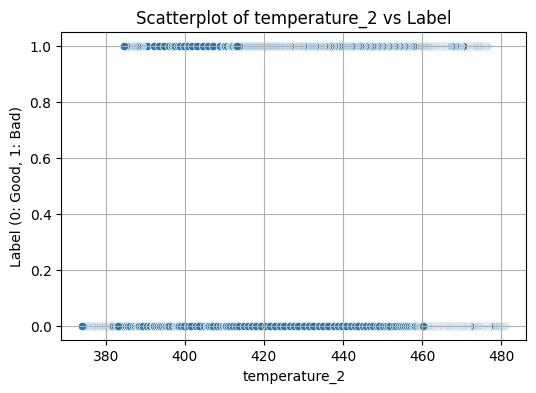

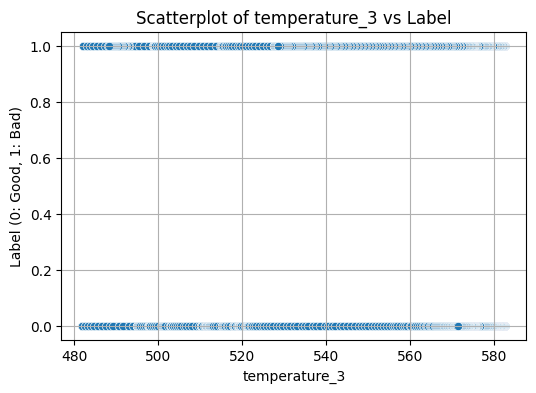

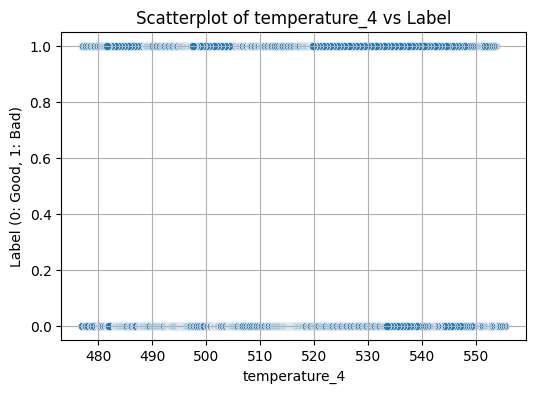

In [15]:
for col in ['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4']:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df['label'].astype(int))  # Ensure label is numeric for plotting
    plt.title(f'Scatterplot of {col} vs Label')
    plt.xlabel(col)
    plt.ylabel('Label (0: Good, 1: Bad)')
    plt.grid(True)
    plt.show()

## Data Preprocessing
* As there are no NULLs no imputation needed
* No categorical data hence no encoding needed
* As the range of temperatures don't vary too much shows scaling is not needed
* Outliers already taken care

## Feature Engineering
* Calculate `min`, `max`, `std` and `mean`
* Calculate `timestamp_std` and `duration` in seconds

In [16]:
df_grouped = df.groupby(by=['part_id', 'label'], as_index=False).agg(['min', 'max', 'std', 'mean'])
df_grouped.columns = df_grouped.columns.to_flat_index().str.join('_')
df_grouped['timestamp_std_in_sec'] = df_grouped.timestamp_std.astype('int')
df_grouped['duration_in_sec'] = (df_grouped.timestamp_max - df_grouped.timestamp_min).astype('int')
df_grouped

,part_id_,label_,timestamp_min,timestamp_max,timestamp_std,timestamp_mean,temperature_1_min,temperature_1_max,temperature_1_std,temperature_1_mean,...,temperature_3_min,temperature_3_max,temperature_3_std,temperature_3_mean,temperature_4_min,temperature_4_max,temperature_4_std,temperature_4_mean,timestamp_std_in_sec,duration_in_sec
0,2124077390649042,0,2024-02-15 00:14:34,2024-02-15 00:19:37,0 days 00:01:27,2024-02-15 00:17:05,436.9,494.2,17.794521,465.332237,...,533.1,580.2,15.990614,561.814803,509.0,545.0,11.474972,525.352632,87,303
1,2124077390829042,0,2024-02-15 00:19:38,2024-02-15 00:24:46,0 days 00:01:29,2024-02-15 00:22:12,439.6,494.5,17.757541,465.626214,...,533.6,580.3,16.056544,561.015534,512.0,548.2,11.595940,527.515858,89,308
2,2124077390979042,0,2024-02-15 00:24:47,2024-02-15 00:30:11,0 days 00:01:33,2024-02-15 00:27:29,437.7,494.2,18.197057,463.950769,...,531.6,581.3,17.250755,560.087692,508.3,547.3,12.263753,526.405846,93,324
3,2124077391129042,0,2024-02-15 00:30:12,2024-02-15 00:35:18,0 days 00:01:28,2024-02-15 00:32:45,436.0,495.1,18.217066,465.624104,...,528.4,579.1,16.984615,558.909772,510.3,545.4,11.176052,525.828339,88,306
4,2124077391439042,0,2024-02-15 00:40:31,2024-02-15 00:45:43,0 days 00:01:30,2024-02-15 00:43:07,438.0,495.3,18.235123,465.583387,...,529.0,576.8,16.528004,555.940895,510.3,545.5,11.144552,525.658147,90,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,2124087522519042,0,2024-02-17 22:20:52,2024-02-17 22:25:53,0 days 00:01:27,2024-02-17 22:23:22,427.2,482.6,17.503942,454.083113,...,517.9,567.1,16.472527,546.208940,504.5,542.9,12.077110,520.246026,87,301
291,2124087522749042,0,2024-02-17 22:25:54,2024-02-17 22:31:02,0 days 00:01:29,2024-02-17 22:28:28,427.6,481.3,17.576073,452.316505,...,519.2,569.1,16.802814,547.556634,502.2,538.7,11.450521,518.962136,89,308
292,2124087522989042,0,2024-02-17 22:31:03,2024-02-17 22:36:08,0 days 00:01:28,2024-02-17 22:33:35,425.6,481.5,17.685494,452.865686,...,520.1,568.7,16.552117,547.173203,504.5,541.3,11.421210,520.197712,88,305
293,2124087523189042,0,2024-02-17 22:36:09,2024-02-17 22:41:14,0 days 00:01:28,2024-02-17 22:38:41,427.1,481.3,17.630531,452.586928,...,519.2,569.4,16.669240,548.060458,504.6,541.5,11.540804,520.903268,88,305


* Drop irrelevant columns: `part_id_`, `timestamp_min`, and `timestamp_max` as we are retaining derived features: `duration_in_sec`, `timestamp_std_in_sec`

In [17]:
df_grouped = df_grouped.drop(columns=['part_id_', 'timestamp_min', 'timestamp_max', 'timestamp_std', 'timestamp_mean'])
df_grouped

,label_,temperature_1_min,temperature_1_max,temperature_1_std,temperature_1_mean,temperature_2_min,temperature_2_max,temperature_2_std,temperature_2_mean,temperature_3_min,temperature_3_max,temperature_3_std,temperature_3_mean,temperature_4_min,temperature_4_max,temperature_4_std,temperature_4_mean,timestamp_std_in_sec,duration_in_sec
0,0,436.9,494.2,17.794521,465.332237,421.7,477.5,17.610242,454.497697,533.1,580.2,15.990614,561.814803,509.0,545.0,11.474972,525.352632,87,303
1,0,439.6,494.5,17.757541,465.626214,425.1,477.5,17.242912,454.659547,533.6,580.3,16.056544,561.015534,512.0,548.2,11.595940,527.515858,89,308
2,0,437.7,494.2,18.197057,463.950769,422.2,476.4,17.890360,452.379077,531.6,581.3,17.250755,560.087692,508.3,547.3,12.263753,526.405846,93,324
3,0,436.0,495.1,18.217066,465.624104,419.8,477.8,18.127361,454.225081,528.4,579.1,16.984615,558.909772,510.3,545.4,11.176052,525.828339,88,306
4,0,438.0,495.3,18.235123,465.583387,424.0,474.8,16.949355,452.107348,529.0,576.8,16.528004,555.940895,510.3,545.5,11.144552,525.658147,90,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,0,427.2,482.6,17.503942,454.083113,414.5,467.5,17.317152,444.299007,517.9,567.1,16.472527,546.208940,504.5,542.9,12.077110,520.246026,87,301
291,0,427.6,481.3,17.576073,452.316505,412.5,461.6,16.422540,438.980259,519.2,569.1,16.802814,547.556634,502.2,538.7,11.450521,518.962136,89,308
292,0,425.6,481.5,17.685494,452.865686,409.6,464.7,17.582063,441.341503,520.1,568.7,16.552117,547.173203,504.5,541.3,11.421210,520.197712,88,305
293,0,427.1,481.3,17.630531,452.586928,412.1,463.2,17.016323,440.109150,519.2,569.4,16.669240,548.060458,504.6,541.5,11.540804,520.903268,88,305


In [19]:
df_grouped.corr()

,label_,temperature_1_min,temperature_1_max,temperature_1_std,temperature_1_mean,temperature_2_min,temperature_2_max,temperature_2_std,temperature_2_mean,temperature_3_min,temperature_3_max,temperature_3_std,temperature_3_mean,temperature_4_min,temperature_4_max,temperature_4_std,temperature_4_mean,timestamp_std_in_sec,duration_in_sec
label_,1.000000,0.104063,0.064220,-0.115963,0.119427,0.034557,-0.034652,-0.142135,0.003304,-0.014846,-0.045089,-0.069593,-0.026685,-0.000077,-0.029518,-0.045417,-0.009761,-0.099786,-0.092495
temperature_1_min,0.104063,1.000000,0.768862,-0.443524,0.917983,0.830558,0.609624,-0.395598,0.739301,0.734753,0.526697,-0.450581,0.650863,0.619859,0.487124,-0.033954,0.597489,-0.177323,-0.203301
temperature_1_max,0.064220,0.768862,1.000000,0.181959,0.883776,0.753532,0.854882,0.150940,0.842504,0.684078,0.801238,0.088769,0.784872,0.780993,0.770017,0.256712,0.814520,0.075457,0.045666
temperature_1_std,-0.115963,-0.443524,0.181959,1.000000,-0.250646,-0.153817,0.304805,0.864928,0.078788,-0.086894,0.373932,0.828867,0.152967,0.192791,0.388008,0.489312,0.267611,0.372824,0.361725
temperature_1_mean,0.119427,0.917983,0.883776,-0.250646,1.000000,0.776000,0.652528,-0.285645,0.766806,0.682639,0.566694,-0.319003,0.666575,0.627774,0.530639,0.038517,0.631820,-0.145985,-0.165201
temperature_2_min,0.034557,0.830558,0.753532,-0.153817,0.776000,1.000000,0.839927,-0.223909,0.940447,0.922116,0.767904,-0.335238,0.871769,0.772613,0.719994,0.283291,0.786661,-0.068354,-0.099465
temperature_2_max,-0.034652,0.609624,0.854882,0.304805,0.652528,0.839927,1.000000,0.313398,0.956946,0.785558,0.929377,0.173014,0.899105,0.849554,0.875567,0.411581,0.891127,0.158591,0.129234
temperature_2_std,-0.142135,-0.395598,0.150940,0.864928,-0.285645,-0.223909,0.313398,1.000000,0.045746,-0.169942,0.343753,0.916938,0.097980,0.185313,0.333347,0.280544,0.233112,0.369935,0.362438
temperature_2_mean,0.003304,0.739301,0.842504,0.078788,0.766806,0.940447,0.956946,0.045746,1.000000,0.868175,0.866814,-0.081511,0.912313,0.824197,0.803046,0.338936,0.853719,0.024180,0.000425
temperature_3_min,-0.014846,0.734753,0.684078,-0.086894,0.682639,0.922116,0.785558,-0.169942,0.868175,1.000000,0.823670,-0.361669,0.934747,0.832732,0.784853,0.329691,0.846977,-0.044889,-0.077271


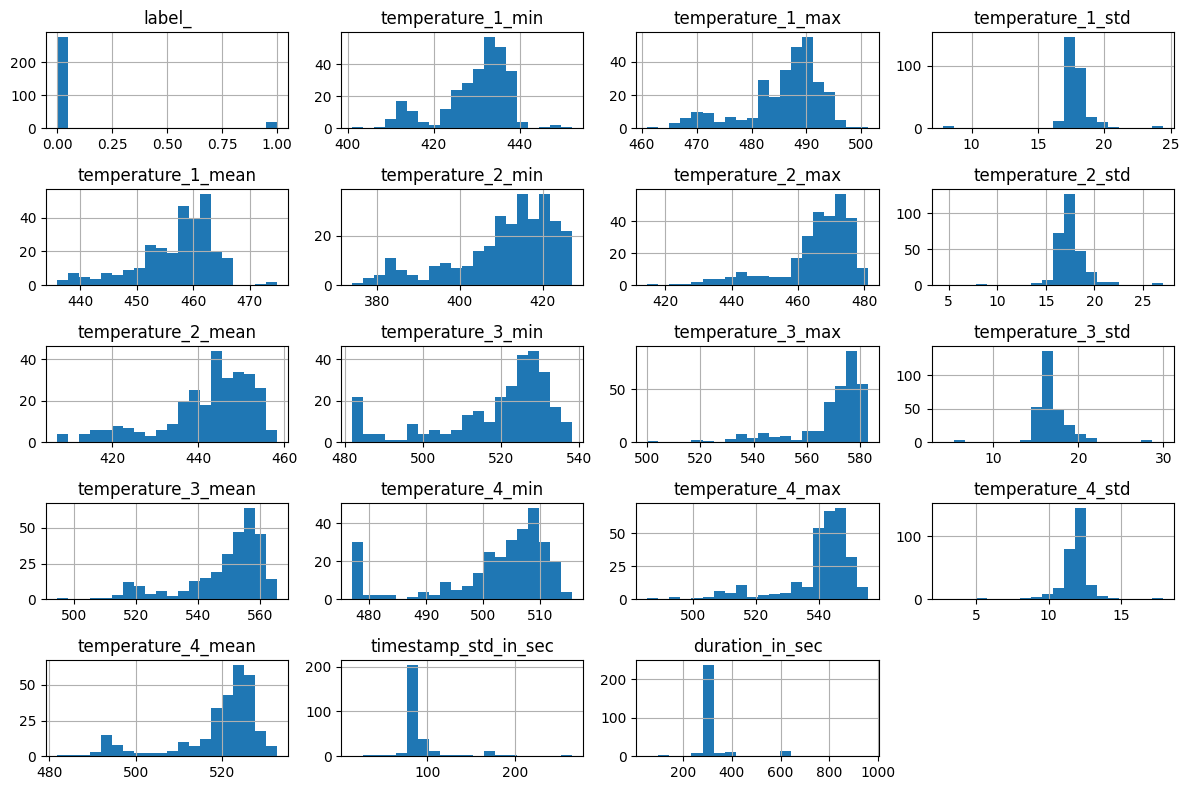

In [20]:
numerical_columns = df_grouped.select_dtypes(include=['float64', 'int64']).columns
df_grouped[numerical_columns].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()